## Rainfall as a function of time from CPOL, WRF

Makes Joy Division plots of the spread of Rainfall rate as a function of time

In [8]:
import pyart
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import glob
from copy import deepcopy
from netCDF4 import Dataset
from scipy import ndimage
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib import colors as mcolors
import glob

Load all grids from computer

In [34]:
data_path = 'C:/Users/rjackson/Documents/data/rainfall_rate/'
conv_strat_path = 'C:/Users/rjackson/Documents/data/conv_stratiform/'
wrf_file = 'C:/Users/rjackson/Documents/data/wrftestdata/wrfout_d01_2006-01-20_000000'
# get_radar_times
#     start_year = Start year of animation
#     start_month = Start month of animation
#     start_day = Start day of animation
#     start_hour = Start hour of animation
#     end_year = End year of animation
#     end_month = End month of animation
#     end_day = End day of animation
#     end_minute = End minute of animation
#     minute_interval = Interval in minutes between scans (default is 5)
# This procedure acquires an array of Radar classes between start_time and end_time  
def get_rain_times(start_year, start_month, start_day,
                   start_hour, start_minute, end_year,
                   end_month, end_day, end_hour, 
                   end_minute, minute_interval=5):

    start_time = datetime(start_year,
                      start_month,
                      start_day,
                      start_hour,
                      start_minute,
                      )
    end_time = datetime(end_year,
                      end_month,
                      end_day,
                      end_hour,
                      end_minute,
                      )

    deltatime = end_time - start_time


    if(deltatime.seconds > 0 or deltatime.minute > 0):
        no_days = deltatime.days + 1
    else:
        no_days = deltatime.days
    
    if(start_day != end_day):
        no_days = no_days + 1
        
    days = np.arange(0, no_days, 1)
    print('We are about to load grid files for ' + str(no_days) + ' days')
    

    # Find the list of files for each day
    cur_time = start_time
 
    file_list = []
    time_list = []
    for i in days:
        year_str = "%04d" % cur_time.year
        day_str = "%02d" % cur_time.day
        month_str = "%02d" % cur_time.month
        format_str = (data_path +
                      'grid_' +
                      year_str +
                      month_str +
                      day_str +
                      '*.nc')
    
    
        print('Looking for files with format ' + format_str)
          
        data_list = glob.glob(format_str)
        
        for j in range(0, len(data_list)):
            file_list.append(data_list[j])
        cur_time = cur_time + timedelta(days=1)
    
    
    # Parse all of the dates and time in the interval and add them to the time list
    past_time = []
    for file_name in file_list:
        date_str = file_name[-18:-3]
        year_str = date_str[0:4]
        month_str = date_str[4:6]
        day_str = date_str[6:8]
        hour_str = date_str[9:11]
        minute_str = date_str[11:13]
        second_str = date_str[13:15]
             
        cur_time = datetime(int(year_str),
                            int(month_str),
                            int(day_str),
                            int(hour_str),
                            int(minute_str),
                            0)
        time_list.append(cur_time)
        
    
    # Sort time list and make sure time are at least xx min apart
    time_list.sort()
    time_list_sorted = deepcopy(time_list)
   
    time_list_final = []
    past_time = []
   
    for times in time_list_sorted:         
        cur_time = times  
        
        if(past_time == []):
            past_time = cur_time
            
        if(cur_time - past_time >= timedelta(minutes=minute_interval)
           and cur_time >= start_time and cur_time <= end_time):
            
            time_list_final.append(cur_time)
            past_time = cur_time
                           
    return time_list_final

# Get a Radar object given a time period in the CPOL dataset
def get_rainfall_grid(time):
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (data_path +
                    'grid_' +
                     year_str +
                     month_str +
                     day_str +
                     '.' +
                     hour_str +
                     minute_str + '*.nc')
    list = glob.glob(file_name_str)
    try:
        radar = pyart.io.read_grid(list[0])
        return radar
    except:
        print('No rainfall grid found!')

def get_conv_strat_wrf(time):
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (conv_strat_path +
                     'conv_strat_wrf' +
                     year_str +
                     month_str +
                     day_str +
                     hour_str +
                     minute_str + 
                     second_str + '.nc')
    print(file_name_str)
    radar = Dataset(file_name_str)
    return radar

def area_anal(pixel_area, rr_x, rain_rates): 
    A_rainrate = np.zeros(rr_x.shape) 
    N_rainrate = np.zeros(rr_x.shape) 
    Rm_rainrate = np.zeros(rr_x.shape) 
    for i in range(len(rr_x)): 
        b_fld = np.zeros(rain_rates.shape) 
        b_fld[rain_rates > rr_x[i]] = 1.0 
        regions, N_rainrate[i] = ndimage.label(b_fld) 
        try: 
            A_rainrate[i] = (len(np.where( regions > 0.5)[0]) * pixel_area) 
            Rm_rainrate[i] = rain_rates[ np.where(regions > 0.5)].mean() 
        except IndexError: 
            A_rainrate[i] = 0.0 
            Rm_rainrate[i] = 0.0 
    return N_rainrate, A_rainrate, Rm_rainrate

In [35]:
times = get_rain_times(2006, 1, 20, 0, 1,
                       2006, 1, 20, 2, 58)
# Make sure start time = WRF start time
print(times)

We are about to load grid files for 1 days
Looking for files with format C:/Users/rjackson/Documents/data/rainfall_rate/grid_20060120*.nc
20060120.000009
20060120.001009
20060120.002009
20060120.003009
20060120.004008
20060120.005008
20060120.010008
20060120.011009
20060120.012009
20060120.013009
20060120.014009
20060120.015009
20060120.020009
20060120.021008
20060120.022009
20060120.023009
20060120.024009
20060120.025009
20060120.030009
[datetime.datetime(2006, 1, 20, 0, 10), datetime.datetime(2006, 1, 20, 0, 20), datetime.datetime(2006, 1, 20, 0, 30), datetime.datetime(2006, 1, 20, 0, 40), datetime.datetime(2006, 1, 20, 0, 50), datetime.datetime(2006, 1, 20, 1, 0), datetime.datetime(2006, 1, 20, 1, 10), datetime.datetime(2006, 1, 20, 1, 20), datetime.datetime(2006, 1, 20, 1, 30), datetime.datetime(2006, 1, 20, 1, 40), datetime.datetime(2006, 1, 20, 1, 50), datetime.datetime(2006, 1, 20, 2, 0), datetime.datetime(2006, 1, 20, 2, 10), datetime.datetime(2006, 1, 20, 2, 20), datetime.date

## Load Rainfall rate for each grid

In [56]:
rain_area_obs = []
rain_num_obs = []
rain_area_wrf = []
rain_num_wrf = []
datenums = np.zeros(len(times))
rr_bins = np.arange(0,100,1)
i = 0
wrf_cdf = Dataset(wrf_file, mode='r')
Z_wrf = wrf_cdf.variables['REFL_10CM'][:,:,:,:]
RAINNC_wrf = wrf_cdf.variables['RAINNC'][:,:,:]

# Rainfall rate assuming 10 min timesteps
Rainfall_rate = np.nan*np.ones(RAINNC_wrf.shape)
Rainfall_rate[1:] = (RAINNC_wrf[1:]-RAINNC_wrf[:-1])*6
for rad_time in times:
    grid = get_rainfall_grid(rad_time)
    N_rr, A_rr, R_rr = area_anal(1, rr_bins, grid.fields['rain_rate_A']['data'][1])
    rain_area_obs.append(A_rr)
    rain_num_obs.append(N_rr)
    N_rr, A_rr, R_rr = area_anal(1, rr_bins, Rainfall_rate[i])
    rain_area_wrf.append(A_rr)
    rain_num_wrf.append(N_rr)
    i = i + 1

C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:164: RuntimeWarning: invalid value encountered in greater


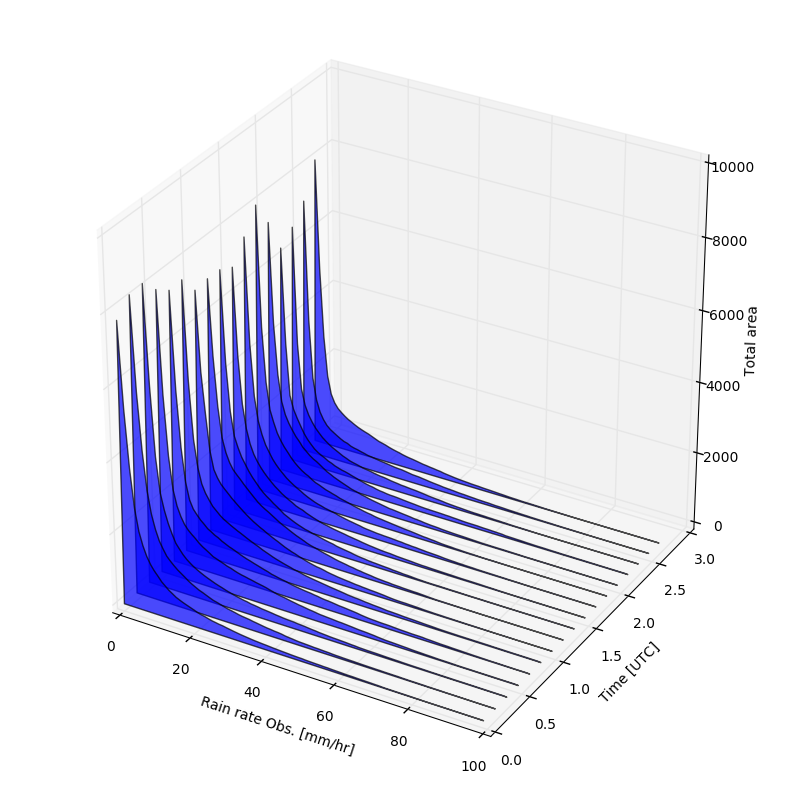

In [58]:
from matplotlib import colors as mcolors
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

def cc(arg):
    return mcolors.to_rgba(arg, alpha=0.6)

xs = rr_bins
verts = []
zs = np.arange(0, len(times), 1.0)
i = 0
for z in zs:
    ys = rain_area_obs[i]
    ys[0], ys[-1] = 0, 0
    verts.append(list(zip(xs, ys)))
    i = i + 1

poly = PolyCollection(verts)
poly.set_alpha(0.7)
ax.add_collection3d(poly, zs=zs/6, zdir='y')

ax.set_xlabel('Rain rate Obs. [mm/hr]')
ax.set_xlim3d(0, 100)
ax.set_ylabel('Time [UTC]')
ax.set_ylim3d(0, 3)
ax.set_zlabel('Total area')
ax.set_zlim3d(0, 10000)

plt.show()

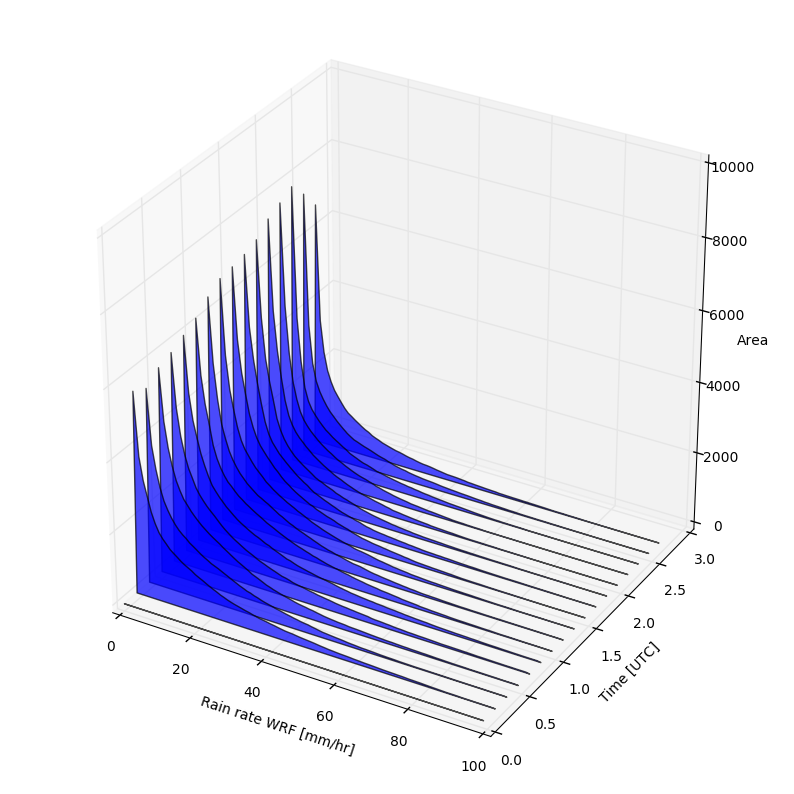

In [57]:
from matplotlib import colors as mcolors
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

def cc(arg):
    return mcolors.to_rgba(arg, alpha=0.6)

xs = rr_bins
verts = []
zs = np.arange(0, len(times), 1.0)
i = 0
for z in zs:
    ys = rain_area_wrf[i]
    ys[0], ys[-1] = 0, 0
    verts.append(list(zip(xs, ys)))
    i = i + 1

poly = PolyCollection(verts)
poly.set_alpha(0.7)
ax.add_collection3d(poly, zs=zs/6, zdir='y')

ax.set_xlabel('Rain rate WRF [mm/hr]')
ax.set_xlim3d(0, 100)
ax.set_ylabel('Time [UTC]')
ax.set_ylim3d(0, 3)
ax.set_zlabel('Area')
ax.set_zlim3d(0, 10000)

plt.show()

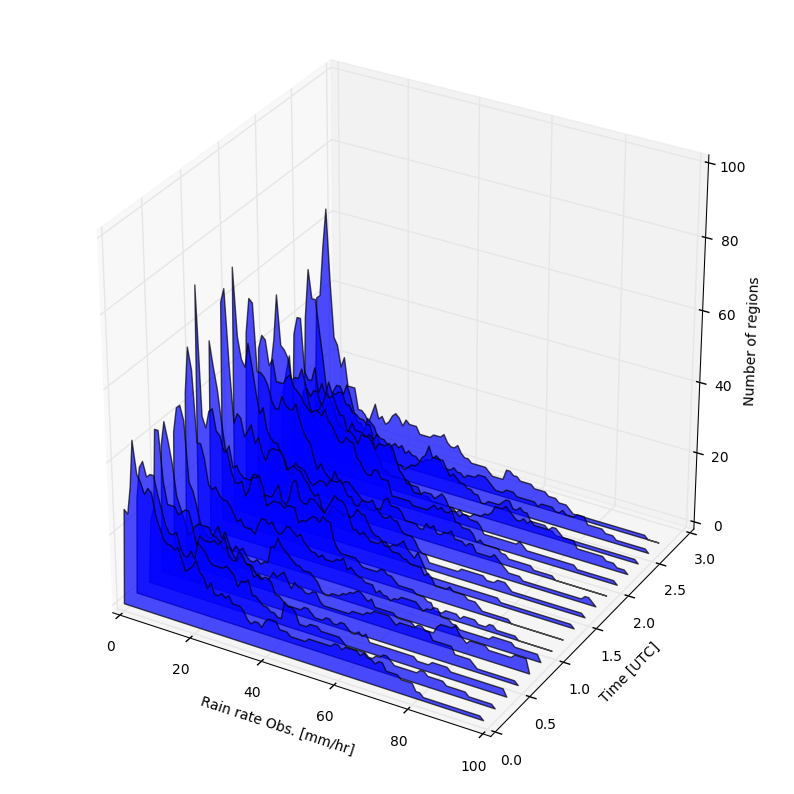

In [60]:
from matplotlib import colors as mcolors
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

def cc(arg):
    return mcolors.to_rgba(arg, alpha=0.6)

xs = rr_bins
verts = []
zs = np.arange(0, len(times), 1.0)
i = 0
for z in zs:
    ys = rain_num_obs[i]
    ys[0], ys[-1] = 0, 0
    verts.append(list(zip(xs, ys)))
    i = i + 1

poly = PolyCollection(verts)
poly.set_alpha(0.7)
ax.add_collection3d(poly, zs=zs/6, zdir='y')

ax.set_xlabel('Rain rate Obs. [mm/hr]')
ax.set_xlim3d(0, 100)
ax.set_ylabel('Time [UTC]')
ax.set_ylim3d(0, 3)
ax.set_zlabel('Number of regions')
ax.set_zlim3d(0, 100)

plt.show()

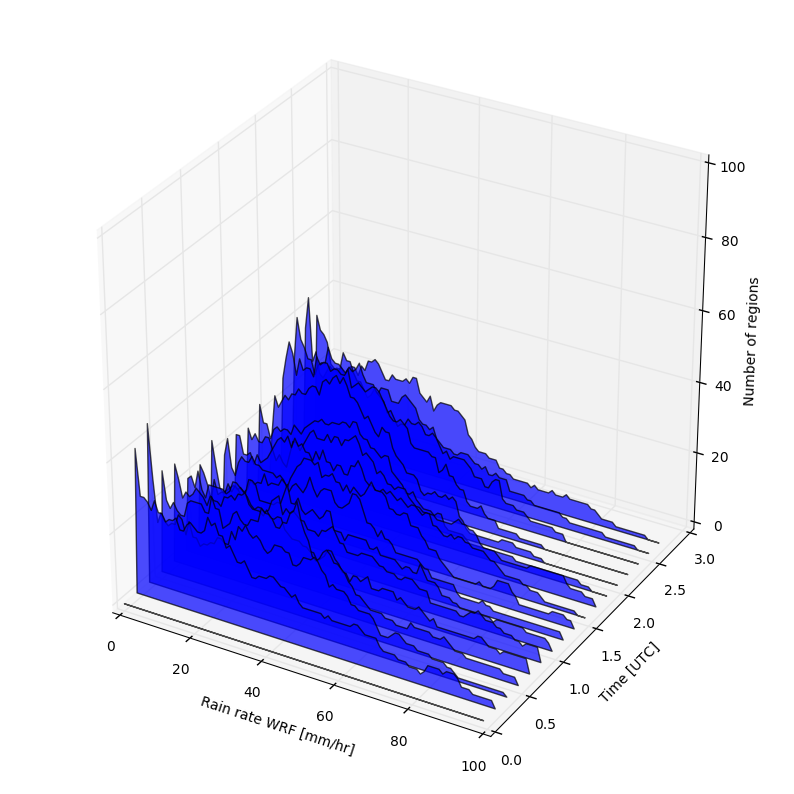

In [61]:
from matplotlib import colors as mcolors
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

def cc(arg):
    return mcolors.to_rgba(arg, alpha=0.6)

xs = rr_bins
verts = []
zs = np.arange(0, len(times), 1.0)
i = 0
for z in zs:
    ys = rain_num_wrf[i]
    ys[0], ys[-1] = 0, 0
    verts.append(list(zip(xs, ys)))
    i = i + 1

poly = PolyCollection(verts)
poly.set_alpha(0.7)
ax.add_collection3d(poly, zs=zs/6, zdir='y')

ax.set_xlabel('Rain rate WRF [mm/hr]')
ax.set_xlim3d(0, 100)
ax.set_ylabel('Time [UTC]')
ax.set_ylim3d(0, 3)
ax.set_zlabel('Number of regions')
ax.set_zlim3d(0, 100)

plt.show()